# **Descritivo do trabalho**

O grupo decidiu por realizar uma análise sobre os indicadores de capacidade da rede 4G de uma operadora celular com os seguintes objetivos:

1.   Considerando uma meta de throughput download médio por usuário de, no mínimo 10 Mbps, levantar através de algoritmos Decision Tree e Random Tree a ordem de importância dos indicadores de capacidade do sistema 4G;

2.   Aplicar modelo de ML que consiga prever quando uma célula (portadora que atende aos usuários) não consegue prover a meta de throughput download médio por usuário (10 Mbps), o que pode ser utilizado para prever esse indicador a partir das séries temporais das variáveis de entrada;

Os dados analisados são provenientes dos relatórios de capacidade das semanas W48 e W49 de 2021, cada linha representa os resultados sumarizados para cada uma das células da rede móvel 4G.

Para infomação, o atendimento dos clientes numa rede móvel celular é baseado em portadoras de rádio que se distribuem em formato hexagonal, daí o nome celular, vide a figura abaixo:

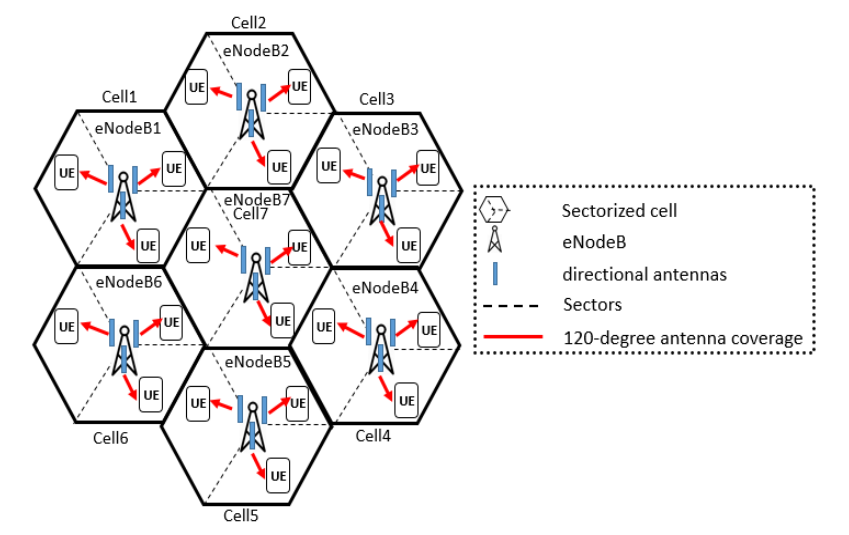

Cada célula apresenta as seguintes características:

*   Banda: É a faixa de frequência na qual a célula opera, na rede LTE ela assume os seguintes valores: 700 MHz, 1800 MHz, 2100 MHz e 2600 MHz. É importante notar que, quanto menor o valor, maior será a propagação da célula;

*   Bandwidth: É a quantidade de espectro que a célula possui, na rede LTE ela varia entre 5 MHz a 20 MHz com passos de 5 MHz. Quanto maior a bandwidth (largura de faixa) mais capacidade a portadora (célula) possui;

Segue abaixo a descrição das dimensões relevantes a este trabalho

*   technology: Classificação da tecnologia, pode ser LTE (4G) ou UMTS (3G), o foco do trabalho é sobre a rede LTE;
*   band: Faixa de frequência (em MHz) na qual a célula opera
*   bandwidth: Largura de faixa das células;
*   rrc_connectedusers: Quantidade de usuários conectados;
*   utilization_prb_dl: Quantidade de recursos percentual de recursos de rádio utilizados - a quantidade de recursos disponível é igual 5 vezes a bandwidth;
*   load_dl: Quantidade percentual da utilização da capacidade em volume de uma célula, que é igual a 1,2 vezes a bandwidth;
*   userthroughput_dl: É o throughput de downlink médio por cliente, é a variável que será classificada entre inferior e superior a 10 Mbps - meta de desempenho;



**Membros do grupo:**



1.   Ana Rucos;
2.   Daniel Galdino;
3.   Leandro Saldini;
4.   Leonardo Lins;
5.   Marcus Vidon;



# Importação das bibliotecas, seed, conexão com google drive

In [ ]:
# Importação dos pacotes
#from google.colab import drive 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import random
seed = 1
random.seed(seed)
np.random.seed(seed)

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTE

#drive.mount('/content/drive')
#import os
#os.chdir('drive/MyDrive/Colab Notebooks')

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import plotly.offline as py
import plotly.graph_objs as go

# Definição de funções

In [ ]:
def predict_and_evaluate(model, X_test, y_test):

    y_pred = model.predict(X_test) 

    # Acurácia
    accuracy = accuracy_score(y_test, y_pred)
    print('Acurácia: ', accuracy)

    # Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print('Kappa: ', kappa)

    # F1
    f1 = f1_score(y_test, y_pred)
    print('F1: ', f1)

    # Matriz de confusão

    confMatrix = confusion_matrix(y_test, y_pred)
    ax = plt.subplot()
    sns.heatmap(confMatrix, annot=True, fmt=".0f")
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')

In [ ]:
def evaluate(y_pred, y_test):

    # Acurácia
    accuracy = accuracy_score(y_test, y_pred)
    print('Acurácia: ', accuracy)

    # Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print('Kappa: ', kappa)

    # F1
    f1 = f1_score(y_test, y_pred)
    print('F1: ', f1)

    # Matriz de confusão
    confMatrix = confusion_matrix(y_test, y_pred)

    ax = plt.subplot()
    sns.heatmap(confMatrix, annot=True, fmt=".0f")
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')

# **Importação dos relatório de Capacidade**

In [ ]:
w48 = pd.read_excel('w48.xlsx')
w49 = pd.read_excel('w49.xlsx')

w48_selected = w48[['technology','band','bandwidth','rrc_connectedusers','utilization_prb_dl','load_dl','traffic','userthroughput_dl']]
w49_selected = w49[['technology','band','bandwidth','rrc_connectedusers','utilization_prb_dl','load_dl','traffic','userthroughput_dl']]


# Concatenando os data frames

frames = [w48_selected, w49_selected]
data = pd.concat(frames, ignore_index=True) # Ignorar Index para evitar repetição

#Filtrando apenas resultados da tecnologia LTE (4G):

data = data.loc[data.technology == 'LTE']

#Filtrando band = 450 -> Faixa de Espectro com pouquíssima utilização e de aplicação restrita

data = data.loc[data.band > 450]

#Corrigindo a informação de Bandwidth:

data['bandwidth'] = data['bandwidth']/1000

#Filtrando BW = 5 MHz
data = data.loc[data.bandwidth > 5]

#Criando Sector Throughput, pois o indicador load_dl indica apenas a carga (%), o que não leva em conta as diferentes BWs existentes:

data['sectorThp'] = data['load_dl']*data['bandwidth']*1.2/100

#Selecionando colunas relevantes:

data = data[['band', 'bandwidth',	'rrc_connectedusers',	'utilization_prb_dl',	'sectorThp',	'userthroughput_dl']]

#One Hot Encoding em Band - Variável Categórica:

data = pd.get_dummies(data, columns = ['band'], prefix= ['band'], prefix_sep = '_')

# Criando a variável de classificação

In [ ]:
#Criando coluna Classe: [1]: usrthp < 10000 e [0]: usrthp >= 10000	

data['CLASSE'] = 0

data.loc[data.userthroughput_dl < 10000, 'CLASSE'] = 1

# Removendo a Coluna Usr Thp e criando as classes de UsrThp > 10000 [0] e UsrThp < 10000 [1]:

data = data[['band_700',	'band_1800',	'band_2100',	'band_2600',	'bandwidth',  'rrc_connectedusers',  'utilization_prb_dl',  'sectorThp',	'CLASSE']]

# **Pré-processamento**

In [ ]:

# Agora usaremos a função para fazer de fato a separação. Já faremos a separação em treino e teste e entrada e saída.
X = data.loc[:,data.columns != 'CLASSE']  # Entrada
y = data.CLASSE    # Saída
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y)

print('Base de Treino: ' + str(y_train.count()))
print('Base de Teste: ' + str(y_test.count()))

Base de Treino: 247578
Base de Teste: 61895


In [ ]:
# remover colunas com variância zero

from sklearn.feature_selection import VarianceThreshold
zero_var_filter = VarianceThreshold()
X_train = zero_var_filter.fit_transform(X_train)
X_test = zero_var_filter.transform(X_test)

# colunas com variância zero
(zero_var_filter.variances_ == 0).sum()

0

,row_index,percent_missing
0,0,0.000969
349126,1,0.000969
349128,2,0.000969
349129,3,0.000969
349130,4,0.000969
...,...,...
104260,457202,0.000000
104259,457203,0.000000
104258,457204,0.000000
104257,457205,0.000000


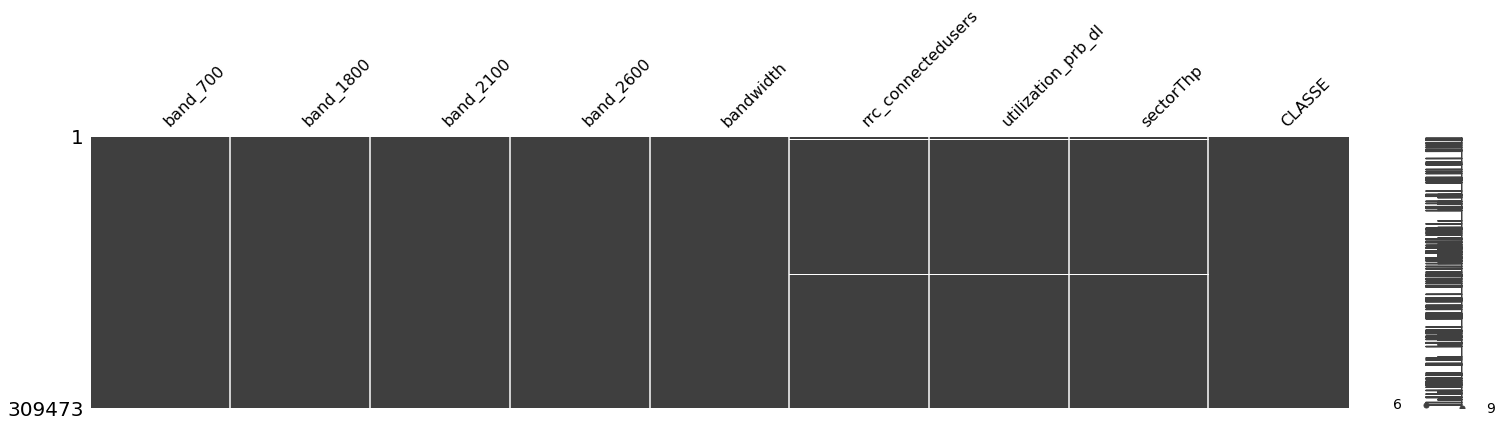

In [ ]:
#Avaliando quantidade de dados nulos:

#Visualizar missing:

msno.matrix(data, figsize=(25,5));

#Verificar Missing por Linha:

percent_missing_rows = data.apply(lambda x: x.isnull().sum()*100/len(data), axis = 1).sort_values(ascending = False)
b = pd.DataFrame({'row_index': data.index, 'percent_missing': percent_missing_rows})
b

In [ ]:
#Tratamento de Valores nulos, utilizando KNN:

imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)


In [ ]:
# Realizando a normalização Min/Max em função da existência das variáveis categóricas geradas pelo one hot encoder:

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # aplico o modelo no treino
X_test = scaler.transform(X_test)   # aplico o modelo no teste


In [ ]:
#Convertendos os Np.Arrays em Dataframes

X_train = pd.DataFrame(X_train, columns=['band_700',	'band_1800',	'band_2100',	'band_2600',	'bandwidth',	'rrc_connectedusers',	'utilization_prb_dl',	'sectorThp'])
X_test = pd.DataFrame(X_test, columns=['band_700',	'band_1800',	'band_2100',	'band_2600',	'bandwidth',	'rrc_connectedusers',	'utilization_prb_dl',	'sectorThp'])

In [ ]:
#Resetando Index y_train e y_test para seguirem o mesmo padrão do X_train e X_test

y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [ ]:
#Avaliando Necessidade de Balanceamento de Classes:
y_train.value_counts()
y_test.value_counts()

0    45775
1    16120
Name: CLASSE, dtype: int64

In [ ]:
#Como as classes não estão demasiadamente desbalaceadas não será necessário aplicar o código abaixo:

"""
oversample = SMOTE(random_state=42, sampling_strategy= 0.2)
X_train, y_train = oversample.fit_resample(X_train, y_train)
"""

'\noversample = SMOTE(random_state=42, sampling_strategy= 0.2)\nX_train, y_train = oversample.fit_resample(X_train, y_train)\n'

Nos próximos tópicos apresentaremos os resultados de diversos modelos de ML. É importante frizar que estamos deixando os scripts do gridsearch apenas como referências, com as opções de parâmetros reduzidas após diversas rodadas para encontrar os valores ótimos.

In [ ]:
# Vamos olhar os shapes da bases de treino e teste
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(247578, 8)
(61895, 8)
(247578,)
(61895,)




# 1.   Árvore de Decisão





In [ ]:
"""
tuned_parameters = [{'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15],
                     'min_samples_leaf': [40, 60, 80]}]

# Executar o grid search
modelDt = GridSearchCV(DecisionTreeClassifier(random_state=seed), tuned_parameters, scoring = 'f1')
modelDt = modelDt.fit(X_train, y_train);
"""


"\ntuned_parameters = [{'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15],\n                     'min_samples_leaf': [40, 60, 80]}]\n\n# Executar o grid search\nmodelDt = GridSearchCV(DecisionTreeClassifier(random_state=seed), tuned_parameters, scoring = 'f1')\nmodelDt = modelDt.fit(X_train, y_train);\n"

In [ ]:
"""
# Melhor Fit

modelDt.best_params_
"""

'\n# Melhor Fit\n\nmodelDt.best_params_\n'

Rodando a árvore de Decisão com os melhores parâmetros

In [ ]:
def trainDt(X_train, y_train, seed):
  model = DecisionTreeClassifier(random_state=seed, criterion = 'gini', max_depth = 15, min_samples_leaf=60) # tente mudar parâmetro para evitar overfitting - Leaf é o número mínimo de registros para ser ter uma folha
  model.fit(X_train, y_train);
  return model

modelDt = trainDt(X_train, y_train, seed)

Avalindo a importância das colunas:

In [ ]:
modelDt.feature_names_in_

array(['band_700', 'band_1800', 'band_2100', 'band_2600', 'bandwidth',
       'rrc_connectedusers', 'utilization_prb_dl', 'sectorThp'],
      dtype=object)

In [ ]:
modelDt.feature_importances_

array([1.99178140e-02, 1.52199665e-03, 2.15420520e-04, 8.47402971e-04,
       2.00280679e-01, 1.94334036e-02, 6.39284195e-01, 1.18499088e-01])

Com relação ao grau de importância têm-se a seguinte ordem de importância:


*   utilization_prb_dl
*   bandwidth
*   sectorThp
*   band_700
*   rrc_connectedusers   
*   band_1800
*   band_2100
*   band_2600

No processo atual de avaliação de capacidade, considera-se o rrc_connectedusers como fator mais importante, ou seja, o estudo demonstra que para se atingir a meta de 10 Mbps em média por usuário se faz necessário reformular o processo existente.






Avaliando a base de treino

Resultados de Treino
Acurácia:  0.9298806840672434
Kappa:  0.814144782942399
F1:  0.8609575984750187


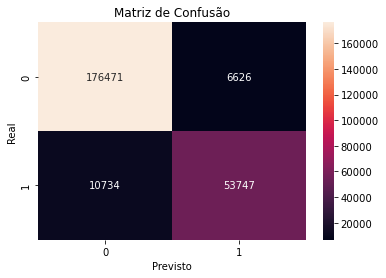

In [ ]:
print('Resultados de Treino')
predict_and_evaluate(modelDt, X_train, y_train)

Avaliando a base de teste

Resultados de Teste
Acurácia:  0.9250504887309152
Kappa:  0.801118550684734
F1:  0.8511184569466286


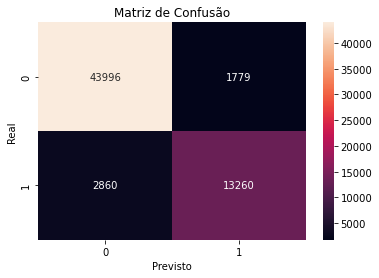

In [ ]:
print('Resultados de Teste')
predict_and_evaluate(modelDt, X_test, y_test)



# 2.   Random Forest



In [ ]:
# Definir parâmetros a serem utilizados
"""
tuned_parameters = [{'n_estimators': [50, 100],
                     'max_features': [0.9, 1],
                     'criterion': ['gini', 'entropy'], 'max_depth': [10, 15],
                     'min_samples_leaf': [40, 60]
                    }]

# Executar o grid search
modelRf = GridSearchCV(RandomForestClassifier(n_jobs=50, verbose=0, random_state = seed), tuned_parameters, scoring='f1')
modelRf = modelRf.fit(X_train, y_train);
"""

In [ ]:
modelRf.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 0.9,
 'min_samples_leaf': 40,
 'n_estimators': 100}

In [ ]:
def trainRf(X_train, y_train, seed):
  model = RandomForestClassifier(n_jobs=50, verbose=0, random_state = seed, criterion = 'entropy',max_depth = 15,
                                 max_features = 0.9, min_samples_leaf = 40,  n_estimators = 100)
  model.fit(X_train, y_train);
  return model

modelRf = trainRf(X_train, y_train, seed)

In [ ]:
modelRf.feature_names_in_

array(['band_700', 'band_1800', 'band_2100', 'band_2600', 'bandwidth',
       'rrc_connectedusers', 'utilization_prb_dl', 'sectorThp'],
      dtype=object)

In [ ]:
modelRf.feature_importances_

array([0.02450586, 0.00329967, 0.00105936, 0.01377565, 0.20831367,
       0.03972858, 0.57694845, 0.13236876])

É perceptível que mais da metade da informação se concetra na ocupação de recursos de rádio e que os resultados de importância, para as 3 variáveis mais importantes, se mantém iguais aos verificados na árvore de decisão. Contudo o rrc_connectedusers ultrapassa o band_700 no algoritmo Random Forest:

*   utilization_prb_dl
*   bandwidth
*   sectorThp
*   rrc_connectedusers   
*   band_700
*   band_1800
*   band_2100
*   band_2600



Resultados de Treino
Acurácia:  0.9324212975304752
Kappa:  0.8204967230407225
F1:  0.8655485820361783


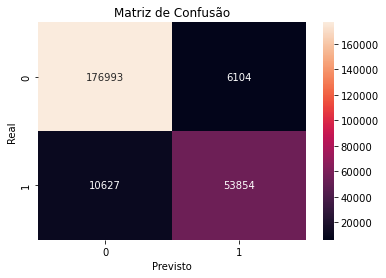

In [ ]:
print('Resultados de Treino')
predict_and_evaluate(modelRf, X_train, y_train)

Resultados de Teste
Acurácia:  0.9271508199369901
Kappa:  0.8063896196227563
F1:  0.8549367821638838


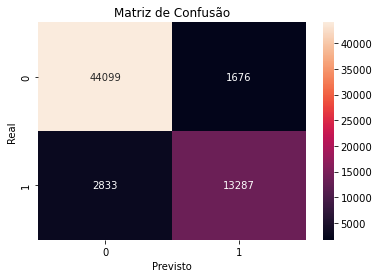

In [ ]:
print('Resultados de Teste')
predict_and_evaluate(modelRf, X_test, y_test)

# 3. XGBoost



Para o XGBoost, em função do tempo de processamento, foi utilizada a mesma parametrização ótima verificada para a árvore de Decisão:

In [ ]:
"""

tuned_parameters = [{'criterion': ['gini'], 'max_depth': [15],
                     'min_samples_leaf': [60], 'subsample' : [0.5, 0.7], 
                     'learning_rate': [0.1, 1],
                     'min_child_weight': [5,10], 'random_state': [seed], 'n_estimators': [100]}]

modelXGB = GridSearchCV(XGBClassifier(objective="binary:logistic", eval_metric='logloss', use_label_encoder=False,
                                ), tuned_parameters, scoring='f1')
modelXGB = modelXGB.fit(X_train, y_train)

"""

'\n\ntuned_parameters = [{\'criterion\': [\'gini\'], \'max_depth\': [15],\n                     \'min_samples_leaf\': [60], \'subsample\' : [0.5, 0.7], \n                     \'learning_rate\': [0.1, 1],\n                     \'min_child_weight\': [5,10], \'random_state\': [seed], \'n_estimators\': [100]}]\n\nmodelXGB = GridSearchCV(XGBClassifier(objective="binary:logistic", eval_metric=\'logloss\', use_label_encoder=False,\n                                ), tuned_parameters, scoring=\'f1\')\nmodelXGB = modelXGB.fit(X_train, y_train)\n\n'

In [ ]:
"""
modelXGB.best_params_
"""

'\nmodelXGB.best_params_\n'

In [ ]:
def trainXGB(X_train, y_train, seed):
  model = XGBClassifier(objective="binary:logistic", eval_metric='logloss', use_label_encoder=False, criterion = 'gini',
 learning_rate = 0.1,
 max_depth = 15,
 min_child_weight = 10,
 min_samples_leaf = 60,
 n_estimators = 100,
 random_state = seed,
 subsample = 0.7)
  model.fit(X_train, y_train);
  return model

modelXGB = trainXGB(X_train, y_train, seed)


[18:25:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Resultados de Treino
Acurácia:  0.942329286123969
Kappa:  0.8477683018842361
F1:  0.8863741265975903


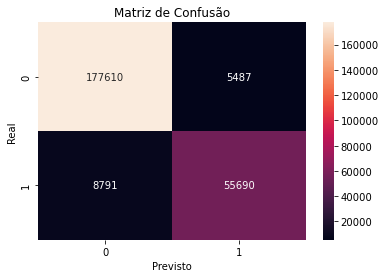

In [ ]:
print('Resultados de Treino')
predict_and_evaluate(modelXGB, X_train, y_train)

Resultados de Teste
Acurácia:  0.9272800710881332
Kappa:  0.8077535250890562
F1:  0.8563862033757699


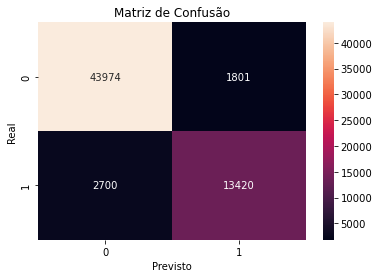

In [ ]:
print('Resultados de Teste')
predict_and_evaluate(modelXGB, X_test, y_test)

# 4.   Regressão Logística



In [ ]:
"""
# Parâmetros a serem testados
tuned_parameters = [{'C': [0.1, 1.0, 10, 20, 50, 100]}]

# Executar o grid search
modelLr = GridSearchCV(LogisticRegression(random_state = seed), tuned_parameters, scoring='f1')
modelLr = modelLr.fit(X_train, y_train)
"""

"\n# Parâmetros a serem testados\ntuned_parameters = [{'C': [0.1, 1.0, 10, 20, 50, 100]}]\n\n# Executar o grid search\nmodelLr = GridSearchCV(LogisticRegression(random_state = seed), tuned_parameters, scoring='f1')\nmodelLr = modelLr.fit(X_train, y_train)\n"

In [ ]:
"""
modelLr.best_params_
"""

'\nmodelLr.best_params_\n'

In [ ]:
def trainLr(X_train, y_train, seed):
  model = LogisticRegression(random_state = seed, C = 100)
  model.fit(X_train, y_train);
  return model

modelLr = trainLr(X_train, y_train, seed)

Resultados de Treino
Acurácia:  0.9064496845438609
Kappa:  0.7498027455125217
F1:  0.8118689637806532


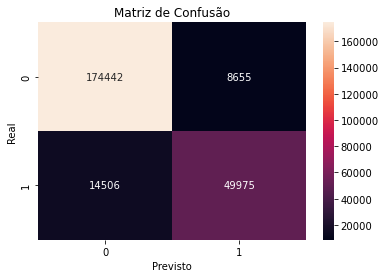

In [ ]:
print('Resultados de Treino')
predict_and_evaluate(modelLr, X_train, y_train)

Resultados de Teste
Acurácia:  0.9069230147831004
Kappa:  0.7507640357597739
F1:  0.8124613431426804


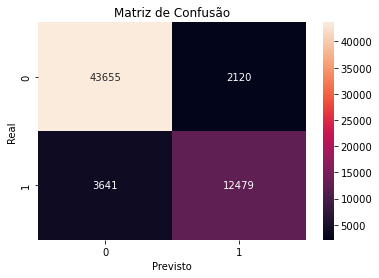

In [ ]:
print('Resultados de Teste')
predict_and_evaluate(modelLr, X_test, y_test)



# 5.   KNN




In [ ]:
"""
# Parâmetros a serem testados
tuned_parameters = [{'n_neighbors': [20, 40, 100]}]

# Executar o grid search
modelKNN = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring='f1')
modelKNN = modelKNN.fit(X_train, y_train)
"""

"\n# Parâmetros a serem testados\ntuned_parameters = [{'n_neighbors': [20, 40, 100]}]\n\n# Executar o grid search\nmodelKNN = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring='f1')\nmodelKNN = modelKNN.fit(X_train, y_train)\n"

In [ ]:
"""
modelKNN.best_params_
"""

'\nmodelKNN.best_params_\n'

In [ ]:
def trainKNN(X_train, y_train, seed):

  model = KNeighborsClassifier(n_neighbors = 40)
  model.fit(X_train, y_train);
  return model

modelKNN = trainKNN(X_train, y_train, seed)


Resultados de Treino
Acurácia:  0.928798196931876
Kappa:  0.8101949345740138
F1:  0.8575446082234289


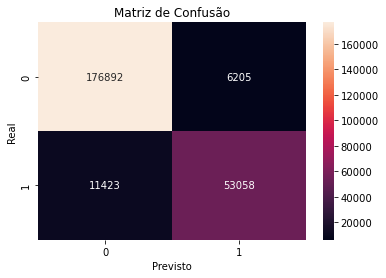

In [ ]:
print('Resultados de Treino')
predict_and_evaluate(modelKNN, X_train, y_train)

Resultados de Teste
Acurácia:  0.9266822845140964
Kappa:  0.8042382465676694
F1:  0.8529392702054572


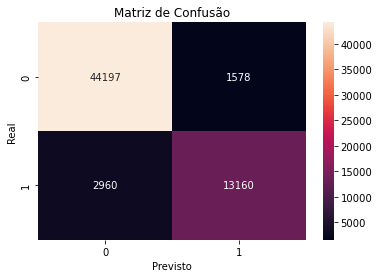

In [ ]:
print('Resultados de Teste')
predict_and_evaluate(modelKNN, X_test, y_test)

# 7.   Comité de Modelos



In [ ]:
comite1 = VotingClassifier(
    estimators=[('DecisionTree', modelDt),
                ('LogistRegression', modelLr),
                ('RandomForest', modelRf),
                ('XGBoost', modelXGB),
                ('KNN', modelKNN)],
    voting='hard')

comite1 = comite1.fit(X_train, y_train)

[18:29:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
comite2 = VotingClassifier(
    estimators=[('DecisionTree', modelDt),
                ('RandomForest', modelRf),
                ('LogistRegression', modelLr),
                ('XGBoost', modelXGB),
                ('KNN', modelKNN)],
    voting='soft')

comite2 = comite2.fit(X_train, y_train)

[18:31:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "criterion", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Resultados de Treino
Acurácia:  0.9336613107788253
Kappa:  0.8235610049611037
F1:  0.8677467669463547


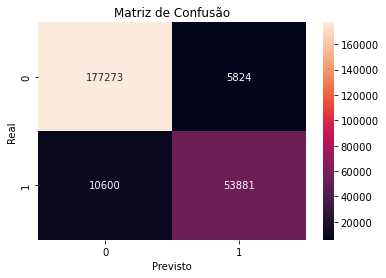

In [ ]:
print('Resultados de Treino')
predict_and_evaluate(comite1, X_train, y_train)

Resultados de Teste
Acurácia:  0.9273123838759189
Kappa:  0.806476614881694
F1:  0.8548569216375779


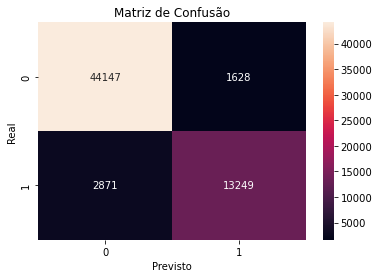

In [ ]:
print('Resultados de Teste')
predict_and_evaluate(comite1, X_test, y_test)

Resultados de Treino
Acurácia:  0.9330473628513034
Kappa:  0.821501822717384
F1:  0.8660222110861447


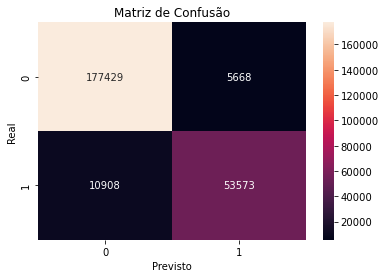

In [ ]:
print('Resultados de Treino')
predict_and_evaluate(comite2, X_train, y_train)

Resultados de Teste
Acurácia:  0.927166976330883
Kappa:  0.8056127498038189
F1:  0.854006088477233


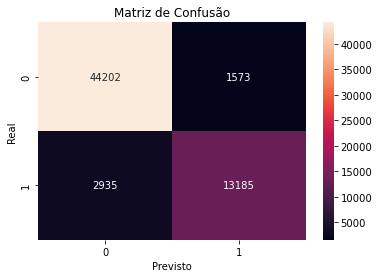

In [ ]:
print('Resultados de Teste')
predict_and_evaluate(comite2, X_test, y_test)

# Conclusões

Os algoritmos testados, em sua grande maioria, apresentaram resultados próximos, o XGBoost aparenta ter melhor relação de compromisso entre os indicadores, sendo ganhador tanto no F1 Score quanto Kappa e por ter acurácia praticamente igual a do Comite Hard (que apresentou a melhor nota desse item);

## Comparação dos resultados de treino

In [ ]:
 acc_pred_train = pd.DataFrame ({'Resultado dos Treinos': ['Acurácia'],
                                 'Árvore de Decisão': accuracy_score(y_train, modelDt.predict(X_train)).ravel(),
                                 'Random Forest': accuracy_score(y_train, modelRf.predict(X_train)).ravel(),
                                 'XGBoost': accuracy_score(y_train, modelXGB.predict(X_train)).ravel(),
                                 'LogReg': accuracy_score(y_train, modelLr.predict(X_train)).ravel(),
                                 'KNN': accuracy_score(y_train, modelKNN.predict(X_train)).ravel(),
                                 'Comité Hard': accuracy_score(y_train, comite1.predict(X_train)).ravel(),
                                 'Comité Soft': accuracy_score(y_train, comite2.predict(X_train)).ravel()
                                 
    })

In [ ]:
kap_pred_train = pd.DataFrame ({'Resultado dos Treinos': ['Kappa'],
                                'Árvore de Decisão': cohen_kappa_score(y_train, modelDt.predict(X_train)).ravel(),
                                'Random Forest': cohen_kappa_score(y_train, modelRf.predict(X_train)).ravel(),
                                'XGBoost': cohen_kappa_score(y_train, modelXGB.predict(X_train)).ravel(),
                                'LogReg': cohen_kappa_score(y_train, modelLr.predict(X_train)).ravel(),
                                'KNN': cohen_kappa_score(y_train, modelKNN.predict(X_train)).ravel(),
                                'Comité Hard': cohen_kappa_score(y_train, comite1.predict(X_train)).ravel(),
                                'Comité Soft': cohen_kappa_score(y_train, comite2.predict(X_train)).ravel()
    })

In [ ]:
f1_pred_train = pd.DataFrame ({'Resultado dos Treinos': ['F1'],
                               'Árvore de Decisão': f1_score(y_train, modelDt.predict(X_train)).ravel(),
                               'Random Forest': f1_score(y_train, modelRf.predict(X_train)).ravel(),
                               'XGBoost': f1_score(y_train, modelXGB.predict(X_train)).ravel(),
                               'LogReg': f1_score(y_train, modelLr.predict(X_train)).ravel(),
                               'KNN': f1_score(y_train, modelKNN.predict(X_train)).ravel(),
                               'Comité Hard': f1_score(y_train, comite1.predict(X_train)).ravel(),
                               'Comité Soft': f1_score(y_train, comite2.predict(X_train)).ravel()
    })

In [ ]:
indicadores_treino = pd.concat([acc_pred_train,kap_pred_train,f1_pred_train], ignore_index=True) # Ignorar Index para evitar repetição

In [ ]:
indicadores_treino = indicadores_treino.set_index('Resultado dos Treinos')
indicadores_treino['Max'] = indicadores_treino.idxmax(axis=1)
indicadores_treino.style.background_gradient(cmap='coolwarm')

,Árvore de Decisão,Random Forest,XGBoost,LogReg,KNN,Comité Hard,Comité Soft,Max
Resultado dos Treinos,,,,,,,,
Acurácia,0.929881,0.932421,0.942329,0.906450,0.928798,0.933661,0.933047,XGBoost
Kappa,0.814145,0.820497,0.847768,0.749803,0.810195,0.823561,0.821502,XGBoost
F1,0.860958,0.865549,0.886374,0.811869,0.857545,0.867747,0.866022,XGBoost


## Comparação dos resultados de teste

In [ ]:
 acc_pred_test = pd.DataFrame ({'Resultado dos Testes': ['Acurácia'],
                                 'Árvore de Decisão': accuracy_score(y_test, modelDt.predict(X_test)).ravel(),
                                 'Random Forest': accuracy_score(y_test, modelRf.predict(X_test)).ravel(),
                                 'XGBoost': accuracy_score(y_test, modelXGB.predict(X_test)).ravel(),
                                 'LogReg': accuracy_score(y_test, modelLr.predict(X_test)).ravel(),
                                 'KNN': accuracy_score(y_test, modelKNN.predict(X_test)).ravel(),
                                 'Comité Hard': accuracy_score(y_test, comite1.predict(X_test)).ravel(),
                                 'Comité Soft': accuracy_score(y_test, comite2.predict(X_test)).ravel()
                                 
    })

In [ ]:
kap_pred_test = pd.DataFrame ({'Resultado dos Testes': ['Kappa'],
                                'Árvore de Decisão': cohen_kappa_score(y_test, modelDt.predict(X_test)).ravel(),
                                'Random Forest': cohen_kappa_score(y_test, modelRf.predict(X_test)).ravel(),
                                'XGBoost': cohen_kappa_score(y_test, modelXGB.predict(X_test)).ravel(),
                                'LogReg': cohen_kappa_score(y_test, modelLr.predict(X_test)).ravel(),
                                'KNN': cohen_kappa_score(y_test, modelKNN.predict(X_test)).ravel(),
                                'Comité Hard': cohen_kappa_score(y_test, comite1.predict(X_test)).ravel(),
                                'Comité Soft': cohen_kappa_score(y_test, comite2.predict(X_test)).ravel()
    })

In [ ]:
f1_pred_test = pd.DataFrame ({'Resultado dos Testes': ['F1'],
                               'Árvore de Decisão': f1_score(y_test, modelDt.predict(X_test)).ravel(),
                               'Random Forest': f1_score(y_test, modelRf.predict(X_test)).ravel(),
                               'XGBoost': f1_score(y_test, modelXGB.predict(X_test)).ravel(),
                               'LogReg': f1_score(y_test, modelLr.predict(X_test)).ravel(),
                               'KNN': f1_score(y_test, modelKNN.predict(X_test)).ravel(),
                               'Comité Hard': f1_score(y_test, comite1.predict(X_test)).ravel(),
                               'Comité Soft': f1_score(y_test, comite2.predict(X_test)).ravel()
    })

In [ ]:
indicadores_testes = pd.concat([acc_pred_test,kap_pred_test,f1_pred_test], ignore_index=True) # Ignorar Index para evitar repetição

In [ ]:
indicadores_testes = indicadores_testes.set_index('Resultado dos Testes')
indicadores_testes['Max'] = indicadores_testes.idxmax(axis=1)
indicadores_testes.style.background_gradient(cmap='coolwarm')

,Árvore de Decisão,Random Forest,XGBoost,LogReg,KNN,Comité Hard,Comité Soft,Max
Resultado dos Testes,,,,,,,,
Acurácia,0.925050,0.927151,0.927280,0.906923,0.926682,0.927312,0.927167,Comité Hard
Kappa,0.801119,0.806390,0.807754,0.750764,0.804238,0.806477,0.805613,XGBoost
F1,0.851118,0.854937,0.856386,0.812461,0.852939,0.854857,0.854006,XGBoost


## Importância dos atributos

Com relação à análise de importância das variáveis podemos concluir que:

Consistentemente o fatores mais significativo foram ocupação de recursos de rádio (utilization_prb_dl), seguido pela capacidade das células (bandwidth) e a quantidade de tráfego cursado (sectorThp);

Nota-se que a informação sobre a faixa utilizada ser de 700 MHz ou não (band_700) tem relevância próxima à quantidade de usuários conectados (rrc_connectedusers), isso pode ser explicado pelo fato das células dessa faixa terem grande área de cobertura (menor perda de propagação) e pouca capacidade (apenas 10 MHz) em comparação às demais;

In [ ]:
# Criando um dataframe com as importancias dos atributos

atributos_dataframe = pd.DataFrame({'atributos': X_train.columns.values,
    'Árvore de Decisão importancia dos atributos': modelDt.feature_importances_,
    'Random Forest importancia dos atributos': modelRf.feature_importances_,
    'XGBoost importancia dos atributos': modelXGB.feature_importances_,
    })

In [ ]:
# Criando uma média dos atributos, setando o index e colorindo o df
atributos_dataframe.set_index('atributos', inplace = True)
atributos_dataframe['média'] = atributos_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
atributos_dataframe.style.background_gradient(cmap='coolwarm')

,Árvore de Decisão importancia dos atributos,Random Forest importancia dos atributos,XGBoost importancia dos atributos,média
atributos,,,,
band_700,0.019918,0.024506,0.038465,0.027629
band_1800,0.001522,0.003300,0.007297,0.004040
band_2100,0.000215,0.001059,0.008522,0.003265
band_2600,0.000847,0.013776,0.009647,0.008090
bandwidth,0.200281,0.208314,0.836853,0.415149
rrc_connectedusers,0.019433,0.039729,0.006913,0.022025
utilization_prb_dl,0.639284,0.576948,0.073789,0.430007
sectorThp,0.118499,0.132369,0.018516,0.089795


## EXTRA - Pós-processamento treino e teste

### Treino

In [ ]:
probabilities = modelXGB.predict_proba(X_train)
probabilities

array([[9.9855781e-01, 1.4422003e-03],
       [1.0907650e-03, 9.9890924e-01],
       [9.9954408e-01, 4.5594524e-04],
       ...,
       [9.9912059e-01, 8.7941258e-04],
       [9.9948120e-01, 5.1879382e-04],
       [9.9961627e-01, 3.8373363e-04]], dtype=float32)

In [ ]:
y_pred = []
for prediction in probabilities:
  if prediction[1] <0.60: #probabilidade da classe 1 (<10)
    y_pred.append(0)
  else:
    y_pred.append(1)

Resultados de Treino
Acurácia:  0.9391020203733773
Kappa:  0.8352993579468705
F1:  0.8753585807230311


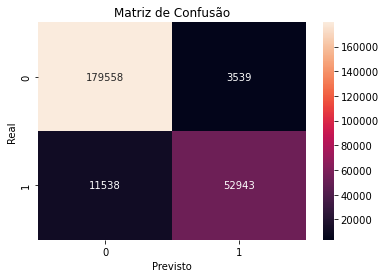

In [ ]:
print('Resultados de Treino')
evaluate(y_pred, y_train)

Resultados de Treino
Acurácia:  0.942329286123969
Kappa:  0.8477683018842361
F1:  0.8863741265975903


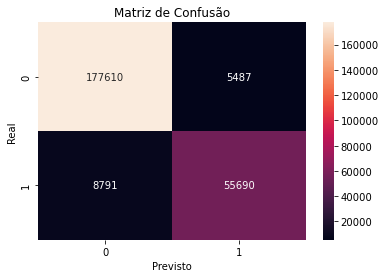

In [ ]:
print('Resultados de Treino')
predict_and_evaluate(modelXGB, X_train, y_train)

### Teste

In [ ]:
probabilities = modelXGB.predict_proba(X_test)
probabilities

array([[9.9651480e-01, 3.4852056e-03],
       [9.9183047e-01, 8.1695132e-03],
       [3.2725394e-02, 9.6727461e-01],
       ...,
       [9.9960250e-01, 3.9750728e-04],
       [4.8536921e-01, 5.1463079e-01],
       [9.9894440e-01, 1.0556118e-03]], dtype=float32)

In [ ]:
y_pred = []
for prediction in probabilities:
  if prediction[1] <0.60: #probabilidade da classe 1 (<10)
    y_pred.append(0)
  else:
    y_pred.append(1)

Resultados de Teste - pós-processamento
Acurácia:  0.9258098392438807
Kappa:  0.7991776383889717
F1:  0.8479470198675497


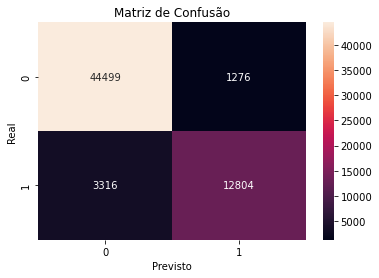

In [ ]:
print('Resultados de Teste - pós-processamento')
evaluate(y_pred, y_test)

Resultados de Teste - modelo
Acurácia:  0.9272800710881332
Kappa:  0.8077535250890562
F1:  0.8563862033757699


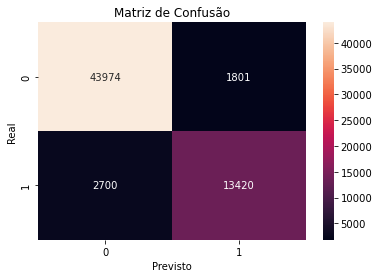

In [ ]:
print('Resultados de Teste - modelo')
predict_and_evaluate(modelXGB, X_test, y_test)